# <center> Porto's Airbnbs: Exploratory Data Analysis </center>

## Notebook Summary

In this notebook I aim to have a look at data on Porto's airbnb listings of March 2022, with the intent of getting a feel for what can potentially affect the price of an airbnb in Porto.

To that end, we will start by having an overview of the available data, perform some data cleaning and lastly perform some exploratory analysis on the data.

The data file used in this notebook was downloaded from this [website](http://insideairbnb.com/get-the-data/), which provides multiple datasets with a [creative commons](https://creativecommons.org/licenses/by/4.0/) license. This particular csv file can be found under "Porto, Norte, Portugal" date 14th of March, 2022. 

## General Data Overview & Data Cleaning

In [1]:
#Import key libraries that we will be using 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
#Import the listings data from a local csv file and create our dataframe

df_airbnb = pd.read_csv("listings_porto.csv")

In [3]:
#Checking the data types to see if we need to make changes

df_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10903 entries, 0 to 10902
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10903 non-null  int64  
 1   listing_url                                   10903 non-null  object 
 2   scrape_id                                     10903 non-null  int64  
 3   last_scraped                                  10903 non-null  object 
 4   name                                          10903 non-null  object 
 5   description                                   10897 non-null  object 
 6   neighborhood_overview                         6713 non-null   object 
 7   picture_url                                   10903 non-null  object 
 8   host_id                                       10903 non-null  int64  
 9   host_url                                      10903 non-null 

### Data Cleaning

By quickly looking at the data, we can see several host related columns that appear to have the wrong data type. Also, if we look at our target variable, the price, the data type does not seem adequate. Let's inspect them to better assess the situation. 

In [4]:
df_airbnb[['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'price']].head(10)

,host_response_time,host_response_rate,host_acceptance_rate,price
0,within an hour,100%,85%,$80.00
1,within an hour,96%,97%,$75.00
2,NaN,NaN,NaN,$66.00
3,NaN,NaN,NaN,$66.00
4,within an hour,100%,93%,$21.00
5,within an hour,100%,100%,$62.00
6,within an hour,100%,93%,$20.00
7,NaN,NaN,100%,$214.00
8,NaN,NaN,NaN,$80.00
9,within an hour,100%,93%,$20.00


"host_response_time" has been assigned a data type that makes sense given the information it holds. However, for the remaining columns, it makes sense to convert them to numerical format for a potential future analysis. 

In [5]:
#The "%" and "$" signs need to removed before we change the data type

df_airbnb['host_response_rate'] = df_airbnb['host_response_rate'].str[:-1].astype('float')/100

df_airbnb['host_acceptance_rate'] = df_airbnb['host_acceptance_rate'].str[:-1].astype('float')/100

df_airbnb['price'] = df_airbnb['price'].str[1:].str.replace(",", "").astype('float')

For the "price" column we had to to use str.replace, before converting it to float data type. That is because numbers with more than 3 digits had a comma between the first and the second digit (e.g: 1,500).

Regarding the "%" and "$" signs, we could have used replace as well, however since the special characters are at the beginning and at the end, I opted to slice the string instead.

While removing the dollar sign from "price" was important to enable us to work with the numbers it stored, we should still keep the unit type visible so that we know what currency is the number in. There are many ways to do this, but in this case I will add the "$" sign to our column title. 

In [6]:
#Rename column "price"

df_airbnb.rename(columns = {'price': 'price($)'}, inplace = True)

The column "bathrooms_text" is also worth a look, as it is not clear what type of information it contains.

In [7]:
df_airbnb['bathrooms_text']

0               2 baths
1                1 bath
2                1 bath
3                1 bath
4        2 shared baths
              ...      
10898            1 bath
10899           0 baths
10900           0 baths
10901           0 baths
10902           0 baths
Name: bathrooms_text, Length: 10903, dtype: object

It contains information about the quantity and type of bathroom(s). These could be split into two distinct columns, one numerical and the other categorical. 

In [8]:
#Splitting bathrooms_text into two separate columns

df_airbnb['bathroom_qty'] = df_airbnb['bathrooms_text'].str.split(" ", expand = True)[0]

df_airbnb['bathroom_type'] = df_airbnb['bathrooms_text'].str.split(" ", expand = True)[1]

df_airbnb[['bathrooms_text','bathroom_qty','bathroom_type']]

,bathrooms_text,bathroom_qty,bathroom_type
0,2 baths,2,baths
1,1 bath,1,bath
2,1 bath,1,bath
3,1 bath,1,bath
4,2 shared baths,2,shared
...,...,...,...
10898,1 bath,1,bath
10899,0 baths,0,baths
10900,0 baths,0,baths
10901,0 baths,0,baths


In [9]:
#Understanding what are the different type of bathrooms

df_airbnb['bathroom_type'].value_counts()

bath         6424
baths        2618
shared        947
private       883
half-bath       4
Name: bathroom_type, dtype: int64

Looking at our categories, we can see "bath" and "baths". Given that we have a column with the quantity, for data quality purposes it would be best to convert all "baths" instances to "bath". 

In [10]:
df_airbnb['bathroom_type'] = df_airbnb['bathroom_type'].replace('baths', 'bath')

df_airbnb['bathroom_type'].value_counts()

bath         9042
shared        947
private       883
half-bath       4
Name: bathroom_type, dtype: int64

It would also be important to understand what does the category "bath" really mean, as it is not very clear based on the other available categories. However, this is something out of the scope of this notebook.

### Null Values

Another thing that might be worthy of inspection is the existance of Null Values, as it can compromise the usefulness of certain variables.

In [11]:
null_columns = df_airbnb.columns[df_airbnb.isnull().any()].to_list() #Retrieve columns that have at least one NaN

(df_airbnb[null_columns].isnull().sum())*100/len(df_airbnb) #Null value percentage for all the columns with null values

description                      0.055031
neighborhood_overview           38.429790
host_name                        0.009172
host_since                       0.009172
host_location                    0.137577
host_about                      50.985967
host_response_time              22.461708
host_response_rate              22.461708
host_acceptance_rate            18.270201
host_is_superhost                0.009172
host_thumbnail_url               0.009172
host_picture_url                 0.009172
host_neighbourhood              94.946345
host_listings_count              0.009172
host_total_listings_count        0.009172
host_has_profile_pic             0.009172
host_identity_verified           0.009172
neighbourhood                   38.429790
bathrooms                      100.000000
bathrooms_text                   0.165092
bedrooms                        10.171512
beds                             1.137302
calendar_updated               100.000000
first_review                    15

## Exploratory Data Analysis

Given that there are 74 columns, the approach we will follow is to select some columns which I deem interesting to analyse, having the impact on the price variable in in mind.

We will start with our target, the price. Afterwards, we will try to understand if some selected features could have any sort of  association with the price.

### Price

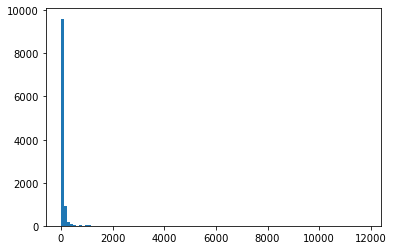

In [12]:
#Using square-root rule as a rule of thumbs for the number of bins

nr_bins_price = int(np.sqrt(len(df_airbnb))) 

plt.hist(df_airbnb['price($)'],bins=nr_bins_price);

We can see that the price distribution is highly skewed to the right, due to the existance of very highly priced listings (outliers). In order to remove that skew, I can perform a logarithmic transformation, taking the logarithm of prices instead. 

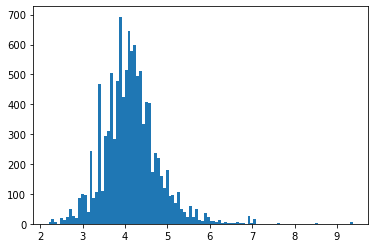

In [13]:
#Log transformation

log_price = np.log(df_airbnb['price($)'])

plt.hist(log_price, bins=nr_bins_price);

The price seems to follow a log-normal distribution. 

### Host

Now we will try to assess if having the host identity verified could impact the price. Other host related features, such as host response time could be analysed, but due to the high percentage of null values (> 20%), those will not be taken into consideration.

In [14]:
#Transforming the variable data and grouping with some aggregation functions

df_airbnb = df_airbnb.replace({'host_identity_verified':{'t':'yes','f':'no'}}) #Replacement to make it easier to understand

df_airbnb.groupby(['host_identity_verified']).agg(avg_price =('price($)','mean'), qty=('price($)','count')).sort_values('avg_price', ascending = True)

,avg_price,qty
host_identity_verified,,
yes,85.958287,8079
no,101.007085,2823


Surprisingly, the price appears to be higher for listings where the host identity is not verified. However, it is important to keep in mind the previous finding: the price distribution is highly skewed, which happens due to very high prices of outliers. 

As such, the mean is not the best measure for us to understand what the typical price scenario is, as it is heavily influenced by the outliers. 

To this end we will calculate the median value, a robust statistic, and re-evaluate the results. 

In [15]:
df_airbnb.groupby(['host_identity_verified']).agg(median_price =('price($)','median'), qty=('price($)','count')).sort_values('median_price', ascending = True)

,median_price,qty
host_identity_verified,,
no,55.0,2823
yes,63.0,8079


Now we see a considerable difference in prices, where having an identified host seems to be linked to higher prices. 

### Size

In this subsection, we take a look at the data to understand how the price of place changes as we increase the number of people it can accommodate.

This time we will observe this graphically, using boxplots and the logarithm of prices.

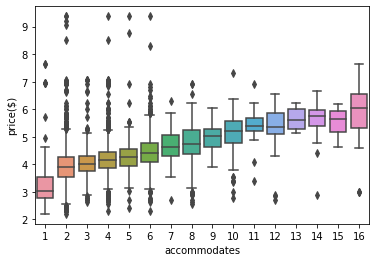

In [16]:
sns.boxplot(data=df_airbnb, x='accommodates', y = log_price);

As our intuition would tell us, we see an increase in price as the number of accommodates increases.

### Amenities

Amenities is one key aspect considered when choosing a place to stay, as there might be some which are essential for that perfect trip. 

Let's take some examples and see how they can impact the prices of airbnbs in Porto.

In [17]:
#Checking the data for the amenities column

df_airbnb['amenities'].head()

0    ["Wine glasses", "Free parking on premises", "...
1    ["Wine glasses", "Carbon monoxide alarm", "Dis...
2    ["Wifi", "Hangers", "Baby safety gates", "Bed ...
3    ["Wifi", "Hangers", "Bed linens", "Baby bath",...
4    ["Hair dryer", "Cooking basics", "Paid parking...
Name: amenities, dtype: object

In [18]:
#Checking the data type

type(df_airbnb['amenities'][0])

str

We can see that our amenities column, while it appears to be of the data type "list", it is in fact "string". This means we cannot loop through these "lists" to extract the individual elements.

Fortunately, each individual amenity is in between quotation marks, making this ideal for the "eval" function. We will still keep the original variable as it might still be useful to have a string version.

In [19]:
df_airbnb['amenities_list'] = df_airbnb['amenities'].apply(eval)

type(df_airbnb['amenities_list'][0])

list

Now the new "amenities_list" column, in the dataframe, is of the "list" type. With this data type change we can proceed with the extraction of the individual elements. For that we will use a custom function. 

In [20]:
def extract_amenities(df): 
    
    un_amn_list = []
    amn_list = []
    
    for row_list in df['amenities_list']:
        for amn in row_list:
            
            amn = amn.lower()           
            
            amn_list.append(amn)
            
            if amn not in un_amn_list:
                un_amn_list.append(amn)
    
    return(amn_list, un_amn_list)

In [21]:
#Applying the customized function to the dataframe

full_amn_list, unique_amn = extract_amenities(df_airbnb)

len(unique_amn)

1002

Having 1002 amenities to choose from, we should try to see what are the most frequent ones and go from there.

In [22]:
#Identifying the 50 most frequent amenities

from collections import Counter

Counter(full_amn_list).most_common(50)

[('wifi', 10357),
 ('essentials', 10201),
 ('long term stays allowed', 10158),
 ('kitchen', 9647),
 ('hair dryer', 9435),
 ('hangers', 8921),
 ('fire extinguisher', 8619),
 ('first aid kit', 8402),
 ('hot water', 8102),
 ('dishes and silverware', 7939),
 ('iron', 7911),
 ('cooking basics', 7617),
 ('microwave', 7316),
 ('refrigerator', 7315),
 ('coffee maker', 7292),
 ('shampoo', 7257),
 ('bed linens', 7039),
 ('dedicated workspace', 6605),
 ('heating', 6341),
 ('stove', 5936),
 ('cable tv', 4923),
 ('oven', 4793),
 ('tv', 4606),
 ('tv with standard cable', 4579),
 ('washer', 4375),
 ('air conditioning', 4302),
 ('smoke alarm', 3856),
 ('extra pillows and blankets', 3753),
 ('private entrance', 3369),
 ('dishwasher', 3286),
 ('host greets you', 3162),
 ('crib', 3083),
 ('free street parking', 3066),
 ('shower gel', 3022),
 ('elevator', 3018),
 ('room-darkening shades', 3008),
 ('luggage dropoff allowed', 2816),
 ('patio or balcony', 2563),
 ('carbon monoxide alarm', 2509),
 ('pack ’n p

Looking at this list count, we can see that amenities such as wifi are very imbalanced, as most places have wifi. Ideally we should look into more balanced amenities, to get a better idea if they influence the price or not. 

Let's start by having a look at stove as an amenity. 

In [23]:
#Use of a list comprehension to quickly check if certain amenities exist in each row 

df_airbnb['has_stove'] = ['stove' in row.lower() for row in df_airbnb['amenities']]

#Aggregation of data to have an idea of how price is impacted by having a stove

df_airbnb.groupby(['has_stove']).agg( median_price = ('price($)', 'median'), qty = ('price($)', 'count'))

,median_price,qty
has_stove,,
False,58.0,4172
True,63.0,6731


Having a stove seems to make the airbnb price go up, which is something that intuitively makes sense. 

Something interesting to observe is that the count here does not match the count we previously obtained in our "full_amn_list". This is most likely due to some entries containing extra details (e.g. brand) before or after the word "stove". The grouping we just did is therefore more accurate, as it includes all stoves.

To check all the "stove" entries in "full_amn_list" and verify this hypothesis, we could import the "fnmatch" module and use the following line of code: fnmatch.filter(full_amn_list, '*stove*')

However, for the sake of the readibility of this notebook, we will skip this step. 

Now let's see how having any sort of free parking can impact price.

In [25]:
df_airbnb['has_parking'] = ['free parking' in row.lower() for row in df_airbnb['amenities']]

df_airbnb.groupby(['has_parking']).agg( median_price = ('price($)', 'median'), qty = ('price($)', 'count'))

,median_price,qty
has_parking,,
False,60.0,8629
True,70.0,2274


The median value for places with some sort of free parking is higher than for those who do not have it.

Obviously, a deeper analysis of amenities would have to be done to truly see the effect on the price, however, as previously mentioned, here the objective is to have a feeling for the data and understand how price is associated with other variables.

### Type of place

For the type of place I will follow the same approach used when analysing size. 

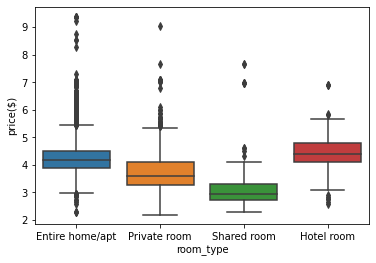

In [26]:
sns.boxplot(data = df_airbnb, x='room_type', y= log_price);

"Private Room" and "Shared Room" accomodation types are typically the cheapest ones, with the "Hotel Room" being the priciest. 

### Location

Location is one of the key factors when choosing an airbnb. Therefore, it is important to try to understand how price changes according to the location.

In [27]:
df_airbnb.groupby(['neighbourhood_group_cleansed']).agg( median_price = ('price($)', 'median'), qty = ('price($)', 'count')).sort_values('median_price')

,median_price,qty
neighbourhood_group_cleansed,,
SÃO JOÃO DA MADEIRA,49.0,22
SANTA MARIA DA FEIRA,50.0,64
MAIA,55.0,103
MATOSINHOS,56.0,447
VILA NOVA DE GAIA,60.0,1205
OLIVEIRA DE AZEMÉIS,60.0,45
PORTO,60.0,7948
VALONGO,65.5,24
PÓVOA DE VARZIM,69.5,256


Not surprisingly we find that most airbnbs are located between Porto's city (where the main tourist attractions are) and Gaia (walking access to Porto). 

However, we see that despite the strong location, the median prices are lower when compared with a less popular destination such as Trofa. Let's try to understand why. 

In [28]:
df_airbnb.groupby(['neighbourhood_group_cleansed', 'room_type']).agg( median_price = ('price($)', 'median'), qty = ('price($)', 'count')).loc[['PORTO', 'TROFA']]

median_price   qty
neighbourhood_group_cleansed room_type                          
PORTO                        Entire home/apt          64.0  6503
                             Hotel room               90.0   120
                             Private room             35.0  1262
                             Shared room              19.0    63
TROFA                        Entire home/apt         120.0    13
                             Private room             20.0     1

Based on the prices it seems that Trofa probably has more "entire homes", rather than "apartment"s which are more typical in a center like Porto, where "entire homes" are almost nonexistant. However, further investigation would be required for us to retrieve and analyse the necessary data and confirm this hypothesis. 

In any case, it is interesting to see that for "Private Room" the prices in Porto are visibly higher, as we would expect for comparable room types. 

In [29]:
df_airbnb[df_airbnb['neighbourhood_group_cleansed'] == 'PORTO'].groupby(['neighbourhood_cleansed']).agg(median_price = ('price($)', 'median'), qty = ('price($)', 'count')).sort_values('median_price', ascending = True)

,median_price,qty
neighbourhood_cleansed,,
Paranhos,38.0,412
Ramalde,44.0,153
Campanhã,52.0,176
Bonfim,54.0,1081
Lordelo do Ouro e Massarelos,61.0,385
"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, Vitória",63.0,5564
"Aldoar, Foz do Douro e Nevogilde",80.0,177


In [30]:
#Median price in Porto

df_airbnb['price($)'].median('neighbourhood_group_cleansed' == "PORTO")

60.0

"Aldoar, Foz do Douro e Nevogilde", "Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, Vitória" and "Lordelo do Ouro e Massarelos" are the priciest areas within Porto, with listing meadian price being above the median price in Porto. 

A quick Google search gives information that confirms the one obtained in this analysis, as the house prices for these areas are also the highest in 2022. 

## Conclusion

We started by inspecting the dataset to get a feel for the data. This was followed by some data cleaning, to ensure it met the format required for this workbook's purposes. 

Last but not least, an EDA was performed, where we looked at various feautures of the dataset, trying to observe potential relationships between those features and the price of our listings in Porto. In the process we found some interesting insights that could serve as base for further research and consequent analysis.  